In [60]:
import re
import random
import pandas as pd
import hashlib

In [61]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [62]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
VMWare,108.015341,2.511985,12.480791,43
Azure Compute Gallery,514.212097,12.855302,23.986057,40
Open Source/GitHub,666.347362,111.057894,181.459450,6
C# Basics,762.237978,24.588322,36.412841,31
WSL + Kali Linux,780.682403,86.742489,264.236845,9
Azure Private DNS,816.864204,42.992853,67.667878,19
RAG Project,942.976065,58.936004,124.089364,16
Azure AD Authentication,1000.330548,76.948504,179.585890,13
Azure Functions + Visual Studio,1090.139429,83.856879,288.088589,13
Audit Report Tracker (Sharepoint List),1127.580062,102.507278,275.974447,11


# Histogram

sum of ages: ~50183.79


<Axes: >

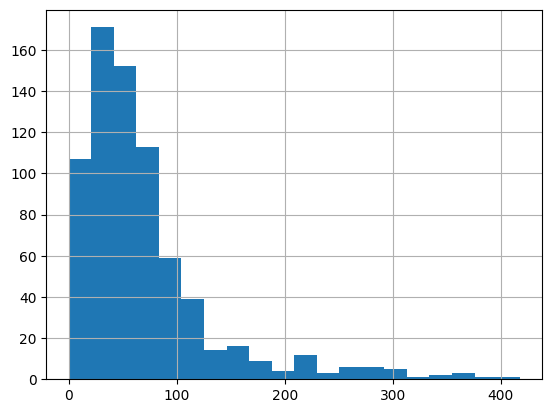

In [63]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [64]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [65]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [66]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [67]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [68]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [69]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [70]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [71]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [72]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [73]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [74]:
n=4
existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 724
Total card age: 50183.79


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold,neg_age
0,Open Source/GitHub,README.md\n\nA markdown file at the root of a ...,fa7339e54e6cae2d01eec1f8a2af3d25,181.459450,111.057894,181.459450,666.347362,0.070115,6,0,0,-181.459450
1,Open Source/GitHub,Hotfix\n\nAn urgent fix applied to a project t...,07a66c6061571c256143d25116985a42,165.771801,111.057894,181.459450,666.347362,0.070115,6,1,0,-165.771801
2,Open Source/GitHub,Good First Issue\n\nA label for beginner-frien...,ee4aff4c065b819d4ed6d2b8c3820ee9,104.413044,111.057894,181.459450,666.347362,0.070115,6,2,0,-104.413044
3,Open Source/GitHub,Contributor\n\nAn individual who contributes c...,38bb149465fee49766142779308d79d1,96.896172,111.057894,181.459450,666.347362,0.070115,6,3,0,-96.896172
4,WSL + Kali Linux,/etc/wsl.conf\nA configuration file in Linux d...,d7247497d7a6816591f382a140abb013,264.236845,86.742489,264.236845,780.682403,0.810769,9,0,0,-264.236845
5,WSL + Kali Linux,"wsl with Docker\nDocker can run on WSL 2, whic...",35482ece9a9fc66928fea68605960010,166.140467,86.742489,264.236845,780.682403,0.810769,9,1,0,-166.140467
6,WSL + Kali Linux,"wsl --update\nUpdates the WSL 2 Linux kernel, ...",ca31a4ff6b4b1feaa1d34462308ee8cb,69.476282,86.742489,264.236845,780.682403,0.810769,9,2,0,-69.476282
7,WSL + Kali Linux,Wireshark Capture Filter\nA set of rules used ...,845ea91c26ec16e6c08be40876be1cd0,61.971759,86.742489,264.236845,780.682403,0.810769,9,3,0,-61.971759
8,Audit Report Tracker (Sharepoint List),View (SharePoint View)\nDefinition: A pre-defi...,c9375efcef5b15bae0f26f4f8d80a3f7,275.974447,102.507278,275.974447,1127.580062,0.980081,11,0,0,-275.974447
9,Audit Report Tracker (Sharepoint List),List Columns Endpoint (for getting column info...,3bd5c040a578b34b790adce8588c4036,215.512473,102.507278,275.974447,1127.580062,0.980081,11,1,0,-215.512473



## Random

In [75]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [76]:
existing_cards.sort_values('age', ascending=False).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold,neg_age
80,Azure Developer Associate,Which Azure Monitor table holds platform metri...,52fbf976aa2ccee89121f7b5694acfce,417.355692,85.843949,417.355692,4721.417170,0.252446,55,0,0,-417.355692
60,PowerShell Modules,Auto-Import\n\nDefinition: A feature in PowerS...,6b1412630951dc5fee8ffa437ee0e0f2,387.051969,98.464950,387.051969,3643.203159,0.586787,37,0,0,-387.051969
76,JavaScript Concepts,Arrow Functions: Arrow functions provide a con...,2e3769781211a560564f81d13f2051b9,375.116630,96.931721,375.116630,5040.449502,0.490472,52,0,0,-375.116630
61,PowerShell Modules,Get-Module\n\nDefinition: A cmdlet that retrie...,0d76065f3213ee411ee6f7e377583cc9,359.619124,98.464950,387.051969,3643.203159,0.586787,37,1,0,-359.619124
44,Terraform,Terraform allows you to manage the resources i...,05fa95392fe5544d07eec6db3a93ccb6,358.008634,81.644390,358.008634,1959.465359,0.644060,24,0,0,-358.008634
56,FSLogix,"During a first-time sign-in, FSLogix creates t...",f2d84db5972e92abd44bdb7e0c5686a7,343.837255,75.429096,343.837255,2564.589253,0.279296,34,0,0,-343.837255
57,FSLogix,Q: Which format does FSLogix use to store user...,2502a81cff9047e83fa1e04a99225de5,338.606675,75.429096,343.837255,2564.589253,0.279296,34,1,0,-338.606675
88,Vocab,"Red Side Story, FForde\nParboil\nPronunciation...",1ee9362f92872e44aac4c6b02749add8,313.734747,62.768425,313.734747,5084.242412,0.351431,81,0,0,-313.734747
28,Logging in Python,Q: What should you do to ensure that logging.b...,b3bbc2d622ec1c54b26be4ee9548cdd4,308.452443,96.621480,308.452443,1642.565157,0.315360,17,0,0,-308.452443
64,Python,Q:\nExplain how itertools.combinations() diffe...,80f75640c457518dd98fc05f857164dd,305.773538,99.844600,305.773538,3893.939405,0.971805,39,0,0,-305.773538


In [77]:
existing_cards.head(10).sum()

head                   Open Source/GitHubOpen Source/GitHubOpen Sourc...
body                   README.md\n\nA markdown file at the root of a ...
hash                   fa7339e54e6cae2d01eec1f8a2af3d2507a66c6061571c...
age                                                           1601.85274
subject_mean_age                                              996.216089
subject_highest_age                                          2334.734076
subject_age_sum                                              8043.279187
head_random_roll                                                5.483695
frequency                                                             82
count                                                                 13
n_fold                                                                 0
neg_age                                                      -1601.85274
dtype: object

In [78]:
existing_cards['age'].mean()

69.314621270924